In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab 
import seaborn as sns

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.3 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=a675a9c49eb3424fb502a9109f66938c71d9a657c072e66b09ed93598b007ebc
  Stored in directory: /tmp/pip-ephem-wheel-cache-zghwazg3/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [3]:
import en_core_web_lg

In [4]:
!pip install pyldavis

In [5]:
import pyLDAvis
import pyLDAvis.gensim_models

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In this notebook, we are going to analyze and compare the complaint reports filed by civilian and police under the scenario where the officers have been disciplined

In [6]:
df_disciplined = pd.read_csv("/content/drive/MyDrive/DSS_CP5/data_cp5_disciplined.csv")
df_disciplined.head()

,crid,incident_year,is_officer_complaint,cr_text,category,allegation_name,text_content,complaint_narrative,officer_id,disciplined,gender,race,rank,current_salary,allegation_count,discipline_count,honorable_mention_count,major_award_count,civilian_compliment_count
0,1061320,2007,True,NaN,Conduct Unbecoming (Off-Duty),Indebtedness To City,AUTO CR - LOG SUMMARY #1061320\n\nTYPE: CR\n\n...,for,12007,True,M,Hispanic,Police Officer,93354.0,33,3,16,0,3
1,1051363,2012,True,Initial / Intake Allegation 1: It is reported ...,Lockup Procedures,Search - Person / Property,AUTO CR - LOG SUMMARY #1051363\n\nTYPE: CR\n\n...,It is reported that the accused officers were\...,25965,True,M,White,Sergeant of Police,107988.0,12,2,25,0,1
2,1051363,2012,True,Initial / Intake Allegation 1: It is reported ...,Lockup Procedures,Search - Person / Property,AUTO CR - LOG SUMMARY #1051363\n\nTYPE: CR\n\n...,SUSTAINED,25965,True,M,White,Sergeant of Police,107988.0,12,2,25,0,1
3,1051363,2012,True,Initial / Intake Allegation 1: It is reported ...,Lockup Procedures,Search - Person / Property,AUTO CR - LOG SUMMARY #1051363\n\nTYPE: CR\n\n...,It is reported that the accused officers were\...,25965,True,M,White,Sergeant of Police,107988.0,12,2,25,0,1
4,1051363,2012,True,Initial / Intake Allegation 1: It is reported ...,Lockup Procedures,Search - Person / Property,AUTO CR - LOG SUMMARY #1051363\n\nTYPE: CR\n\n...,"The reporting party, Sgt. William KAPPEL, star...",25965,True,M,White,Sergeant of Police,107988.0,12,2,25,0,1


In [ ]:
df_disciplined.shape

(1501, 19)

In [ ]:
df_disciplined["crid"].nunique()

392

In [7]:
df_disciplined_fil = df_disciplined.drop_duplicates(subset=['crid'])
df_disciplined_fil.shape

(392, 19)

In [ ]:
df_disciplined_fil["is_officer_complaint"].value_counts()

True     345
False     47
Name: is_officer_complaint, dtype: int64

let's start our analysis with civilian complaints


In [8]:
df_civ_complaints = df_disciplined_fil[df_disciplined_fil['is_officer_complaint'] == False]
df_civ_complaints.shape

(47, 19)

Let us look at some of the type of complaint categories and allegation names, this will help us later in understanding how similar the topic modeling results are with respect to the actual categories and allegation names

In [ ]:
df_civ_complaints["category"].value_counts()

Operation/Personnel Violations    25
Lockup Procedures                  5
Conduct Unbecoming (Off-Duty)      4
Illegal Search                     3
Use Of Force                       3
Traffic                            2
Criminal Misconduct                2
Domestic                           1
Drug / Alcohol Abuse               1
Supervisory Responsibilities       1
Name: category, dtype: int64

In [ ]:
df_civ_complaints["allegation_name"].value_counts()

Inadequate / Failure To Provide Service               17
Prisoners Property                                     4
Miscellaneous                                          4
Improper Search Of Vehicle                             3
Neglect Of Duty                                        2
Slow / No Response                                     2
Association With Felon                                 2
Improper Processing / Reporting / Procedures           1
Reports                                                1
Conspiracy To Commit A Crime                           1
Damage / Trespassing To Property                       1
Indebtedness To City                                   1
Insubordination                                        1
Intoxicated Off Duty                                   1
Fail To Obtain A Complaint Register Number             1
Excessive Force / On Duty - No Injury                  1
Altercation / Disturbance - Neighbor                   1
Leaving Assignment (District, B

In [9]:
complaint_narrative_civ = df_civ_complaints["complaint_narrative"].tolist()

In [10]:
nlp = en_core_web_lg.load()

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [11]:
def create_complaint_corpus(complaint_list, custom_lemmas=[]):
    
    corpus = []
    words_dict = {}
    
    for cur_complaint in complaint_list:

      cur_complaint_tokens = []  
      doc = nlp(cur_complaint.lower())

      for token in doc:
        
        if token.lemma_ != '-PRON-' and len(token.lemma_) > 1 and not token.is_space and not token.is_stop and not token.is_punct and not token.like_num:

          if token.lemma_ not in custom_lemmas:
            
            cur_complaint_tokens.append(token.lemma_)
            words_dict[token.lemma_] = words_dict.get(token.lemma_, 0) + 1
            
      if len(cur_complaint_tokens) > 0:
        corpus.append(cur_complaint_tokens)
                
                
    return (corpus, words_dict)

In [12]:
def plot_word_count_bar_chart(word_dict, num_of_words, type_of_report, x_label='Word', y_label='Count'):
  #convert the word dict to list of items and then sort it by count and showcase the top n words with most frequency
  word_count_list = sorted(list(word_dict.items()), reverse=True, key=lambda word: word[1])[0:num_of_words]
  word_count_df = pd.DataFrame(word_count_list, columns=[x_label, y_label])
  ax = sns.barplot(x=x_label, y=y_label, data=word_count_df)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=65)
  ax.set_title('Most frequent words in the ' + type_of_report + ' complaint reports')
  plt.show()

from our prior analysis in another topic modeling notebook of CP5, we have found some custom stop words

In [13]:
custom_stop_words = ["accuse", "report", "officer", "allege", "city", "chicago", "police", "party", "complainant", "victim", "provide"]

In [16]:
corpus_civ, words_dict_civ = create_complaint_corpus(complaint_narrative_civ, custom_stop_words)

In [17]:
len(corpus_civ)

47

let us look at some sample corpus

In [ ]:
for cur_corpus in corpus_civ[0:5]:
  print(cur_corpus)
  print('==============================================')

['fail', 'return', 'inventory', 'purse']
['rude', 'unprofessional', 'search', 'warrant', 'serve', 'reporting', 'scream', 'face', 'fuck', 'fuck', 'look', 'complaint', 'respond', 'complaint', 'knowledge', 'talk', 'complete', 'field', 'contact', 'card', 'nephew', 'nephew', 'take', 'picture', 'appear', 'take', 'picture', 'stand', 'street', 'subsequently', 'ir', 'excessive', 'force', 'reportng', 'serve', 'search', 'warrant', 'apartment', 'wreck', 'apartment', 'basement', 'garage', 'tear', 'dry', 'wall', 'wall', 'pull', 'insulation', 'pull', 'ceiling', 'tear', 'bath', 'tub', 'floor', 'flip', 'break', 'furnace', 'washer', 'pull', 'heating', 'vent', 'floor', 'ceiling', 'remove', 'food', 'refrigerator', 'sink', 'spoil', 'throw', 'clothing', 'house', 'son', 'bicycle', 'kitchen', 'sink', 'break', 'window', 'garage', 'hit', 'garage', 'door', 'sledge', 'hammer', 'cause', 'door', 'hit', 'vehicle', 'park', 'garage', 'damage', 'rear', 'cause', 'scratch', 'slight', 'dent', 'transfer', 'white', 'paint',

In [ ]:
sns.set(font_scale=1.5)
pylab.rcParams['figure.figsize'] = 18, 6

let us look at the word count distribution in civilian reports

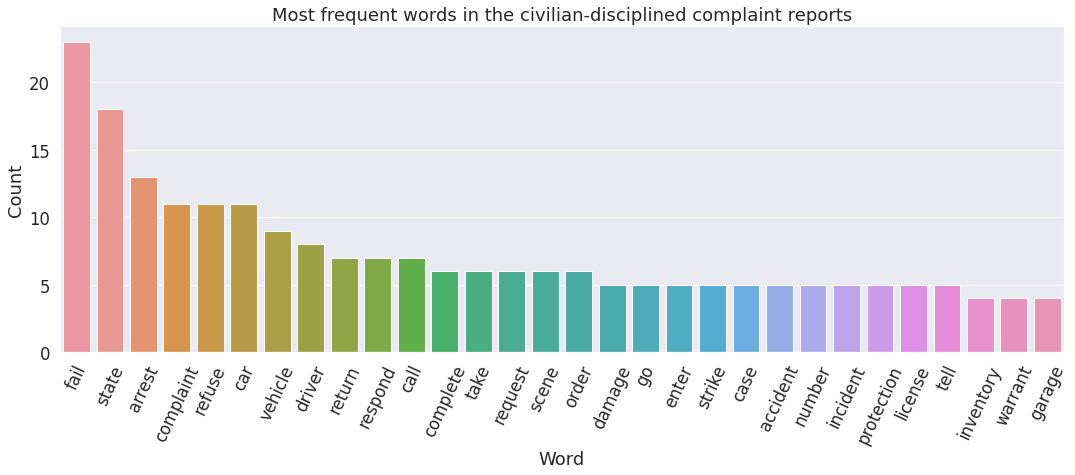

In [ ]:
plot_word_count_bar_chart(words_dict_civ, num_of_words=30, type_of_report='civilian-disciplined')

In [18]:
bigram_civ = gensim.models.Phrases(corpus_civ)
corpus_civ_with_bigram = [bigram_civ[cur_complaint] for cur_complaint in corpus_civ]

In [19]:
dictionary_civ = Dictionary(corpus_civ_with_bigram)
print(dictionary_civ)

Dictionary(425 unique tokens: ['fail', 'inventory', 'purse', 'return', 'apartment']...)


In [20]:
corpus_civ_for_topic_model = [dictionary_civ.doc2bow(cur_complaint) for cur_complaint in corpus_civ_with_bigram]

we are going to try with Latent Dirichlet Allocation (LDA) model, here we need to pass the number of topics, based on the coherence score we can figure out the best "number of topics"

In [ ]:
best_ldaModel_civ = None
best_coherence_val = 0
for num_topics in [3, 5, 8, 10, 15]:

  ldaModel = LdaModel(corpus=corpus_civ_for_topic_model, num_topics=num_topics, id2word=dictionary_civ)
  coherenceModel = CoherenceModel(model=ldaModel, texts=corpus_civ_with_bigram, dictionary=dictionary_civ, coherence='c_v')
  coherence_val = coherenceModel.get_coherence()
  print('Number of Topics', num_topics)
  print('Coherence Value', coherence_val)
  if coherence_val > best_coherence_val:
    best_coherence_val = coherence_val
    best_ldaModel_civ = ldaModel

Number of Topics 3
Coherence Value 0.3474739616186633
Number of Topics 5
Coherence Value 0.4423622050481605
Number of Topics 8
Coherence Value 0.38698400669130695
Number of Topics 10
Coherence Value 0.3140707553355784
Number of Topics 15
Coherence Value 0.4400048883739584


In [ ]:
best_ldaModel_civ.show_topics()

[(0,
  '0.023*"fail" + 0.016*"case" + 0.014*"return" + 0.013*"arrest" + 0.012*"driver" + 0.012*"strike" + 0.011*"domestic" + 0.011*"event" + 0.011*"incident" + 0.011*"enter"'),
 (1,
  '0.032*"state" + 0.021*"complaint" + 0.017*"fail" + 0.011*"car" + 0.011*"arrest" + 0.011*"license" + 0.011*"driver" + 0.010*"enter" + 0.009*"refuse" + 0.008*"unprofessional"'),
 (2,
  '0.034*"refuse" + 0.020*"moe" + 0.020*"mostafa" + 0.020*"request" + 0.017*"accident" + 0.016*"car" + 0.016*"state" + 0.015*"phone" + 0.015*"scene" + 0.015*"witness"'),
 (3,
  '0.026*"state" + 0.017*"test" + 0.017*"joke" + 0.014*"return" + 0.014*"inventory" + 0.013*"fail" + 0.010*"receive" + 0.010*"send" + 0.010*"mail" + 0.009*"kick"'),
 (4,
  '0.033*"fail" + 0.016*"complete" + 0.014*"arrest" + 0.013*"order" + 0.013*"protection" + 0.013*"vehicle" + 0.012*"complaint" + 0.011*"howard" + 0.011*"franklin" + 0.010*"tell"')]

Next we are going to use the pyLDAvis package to visualize the best LDA model results

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(best_ldaModel_civ, corpus_civ_for_topic_model, dictionary_civ)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.077797 -0.002477       1        1  37.563991
1      0.113779 -0.012675       2        1  27.920231
0     -0.030603  0.083770       3        1  16.125832
2     -0.030390 -0.099803       4        1  14.369811
3      0.025010  0.031186       5        1   4.020134, topic_info=        Term       Freq      Total Category  logprob  loglift
66     state  11.000000  11.000000  Default  30.0000  30.0000
124   refuse   7.000000   7.000000  Default  29.0000  29.0000
3     return   4.000000   4.000000  Default  28.0000  28.0000
337      moe   2.000000   2.000000  Default  27.0000  27.0000
338  mostafa   2.000000   2.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
0       fail   0.391338  16.815489   Topic5  -4.3694  -0.5466
158  license   0.191872   3.851070   Topic5  -5.0822   0.2146
103   driver   0.181037   6.124889   Topic5  -5.1403  -0.3076
105   female   0.167161   2.528129   Topic5  -5.2200   0.4976
176      car   0.166004   7.734487   Topic5  -5.2270  -0.6276

[281 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
374       3  0.822556     001st
85        3  0.824428  15-year-
400       2  0.746104      @ble
96        1  0.282689  accident
96        4  0.565379  accident
...     ...       ...       ...
416       2  0.746111      wian
126       2  0.349916   witness
126       4  0.699832   witness
355       1  0.508264      yell
355       3  0.508264      yell

[272 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 3, 4])

In [ ]:
best_ldaModel_civ.save("/content/drive/MyDrive/DSS_CP5/best_ldaModel_civ.model")

In [21]:
loaded_ldaModel_civ = LdaModel.load("/content/drive/MyDrive/DSS_CP5/best_ldaModel_civ.model")

In [35]:
#pyLDAvis.enable_notebook()
#pyLDAvis.gensim_models.prepare(loaded_ldaModel_civ, corpus_civ_for_topic_model, dictionary_civ)

In [23]:
ldaModel_civ_vis = pyLDAvis.gensim_models.prepare(loaded_ldaModel_civ, corpus_civ_for_topic_model, dictionary_civ)
pyLDAvis.save_html(ldaModel_civ_vis, "/content/drive/MyDrive/DSS_CP5/ldaModel_civ_vis.html")

Let us now analyze the complaint reports which was filed by the police and the officers were disciplined

In [24]:
df_pol_complaints = df_disciplined_fil[df_disciplined_fil['is_officer_complaint'] == True]
df_pol_complaints.shape

(345, 19)

Let us look at some of the type of complaint categories and allegation names, this will help us later in understanding how similar the topic modeling results are with respect to the actual categories and allegation names

In [ ]:
df_pol_complaints['category'].value_counts()

Operation/Personnel Violations    209
Conduct Unbecoming (Off-Duty)      87
Lockup Procedures                  24
Drug / Alcohol Abuse               11
Criminal Misconduct                 5
Bribery / Official Corruption       3
Use Of Force                        2
Traffic                             1
Illegal Search                      1
Supervisory Responsibilities        1
False Arrest                        1
Name: category, dtype: int64

In [ ]:
df_pol_complaints['allegation_name'].value_counts()[0:25]

Neglect Of Duty                                            77
Indebtedness To City                                       70
Miscellaneous                                              29
Weapon / Ammunition                                        23
Insubordination                                            22
Misuse Of Department Equipment / Supplies                  15
Association With Felon                                     13
Escape                                                     13
Inventory Procedures                                       10
Leaving Assignment (District, Beat, Sector, Court)          9
Seat Belts                                                  9
Search - Person / Property                                  4
Intoxicated On Duty                                         4
Absent Without Permission                                   4
Prisoners Property                                          4
Court Attendance Irregularities                             3
D.U.I. -

In [25]:
complaint_narrative_pol = df_pol_complaints["complaint_narrative"].tolist()

In [26]:
corpus_pol, words_dict_pol = create_complaint_corpus(complaint_narrative_pol, custom_stop_words)

In [27]:
len(corpus_pol)

331

let us look at some sample corpus

In [ ]:
for cur_corpus in corpus_pol[0:5]:
  print(cur_corpus)
  print('==============================================')

['inattentative', 'duty', 'fail', 'properly', 'search', 'prisoner', 'property', 'bag', 'pack', 'result', 'retrieve', 'bag', 'green', 'leafy', 'substance', 'suspect', 'cannabis', 'inventorie', 'time', 'inattentative', 'duty', 'fail', 'properly', 'search', 'prisoner', 'property', 'bag', 'pack', 'result', 'retrieve', 'bag', 'green', 'leafy', 'substance', 'suspect', 'cannabis', 'inventorie', 'time']
['submit', 'false', 'identify', 'participate', 'arrest', 'identify', 'arrest', 'second', 'arrest', 'submit', 'false', 'identify', 'participate', 'arrest', 'identify', 'arrest', 'second', 'arrest']
['fail', 'department', 'current', 'address']
['sign', 'radio', 'leave', 'partner', 'today', 'date', 'able', 'locate', 'radio']
['inattentive', 'duty', 'fail', 'properly', 'secure', 'weapon', 'go', 'fitting', 'room', 'carson', 'pirie', 'scott', 'leave', 'duty', 'weapon', 'fitting', 'room', 'weapon', 'recover', 'hammond', 'department']


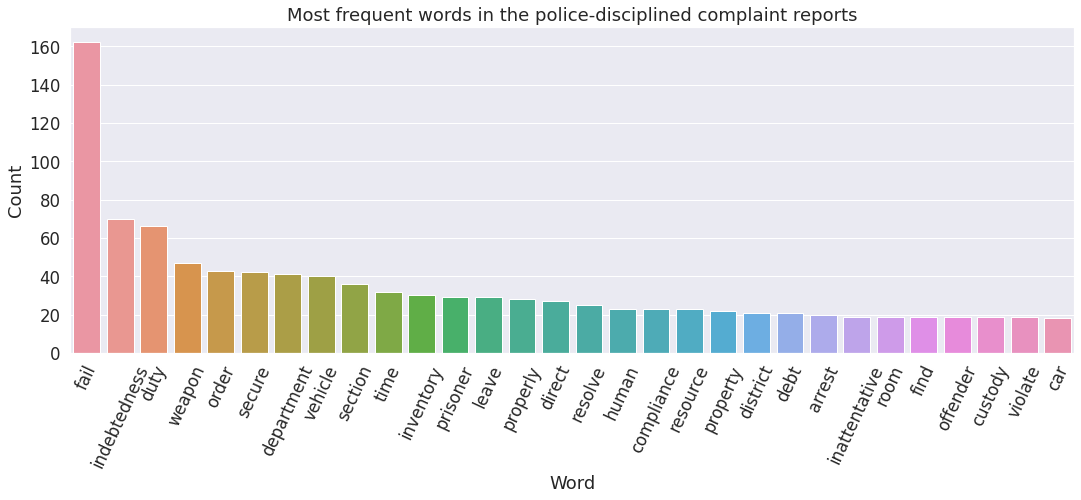

In [ ]:
plot_word_count_bar_chart(words_dict_pol, num_of_words=30, type_of_report='police-disciplined')

In [28]:
bigram_pol = gensim.models.Phrases(corpus_pol)
corpus_pol_with_bigram = [bigram_pol[cur_complaint] for cur_complaint in corpus_pol]

In [29]:
dictionary_pol = Dictionary(corpus_pol_with_bigram)
print(dictionary_pol)

Dictionary(1132 unique tokens: ['bag', 'cannabis', 'fail_properly', 'green', 'inattentative_duty']...)


In [30]:
corpus_pol_for_topic_model = [dictionary_pol.doc2bow(cur_complaint) for cur_complaint in corpus_pol_with_bigram]

we are going to try with Latent Dirichlet Allocation (LDA) model, here we need to pass the number of topics, based on the coherence score we can figure out the best "number of topics"

In [ ]:
best_ldaModel_pol = None
best_coherence_val = 0
for num_topics in [3, 5, 8, 10, 15]:

  ldaModel = LdaModel(corpus=corpus_pol_for_topic_model, num_topics=num_topics, id2word=dictionary_pol)
  coherenceModel = CoherenceModel(model=ldaModel, texts=corpus_pol_with_bigram, dictionary=dictionary_pol, coherence='c_v')
  coherence_val = coherenceModel.get_coherence()
  print('Number of Topics', num_topics)
  print('Coherence Value', coherence_val)
  if coherence_val > best_coherence_val:
    best_coherence_val = coherence_val
    best_ldaModel_pol = ldaModel

Number of Topics 3
Coherence Value 0.4642141918227911
Number of Topics 5
Coherence Value 0.41050223788609497
Number of Topics 8
Coherence Value 0.46513365822195474
Number of Topics 10
Coherence Value 0.44409424866042
Number of Topics 15
Coherence Value 0.4293151886679532


In [ ]:
best_ldaModel_pol.show_topics()

[(0,
  '0.029*"leave" + 0.025*"subject" + 0.022*"fail" + 0.012*"relieve" + 0.011*"district" + 0.011*"room" + 0.010*"discover" + 0.009*"2nd" + 0.009*"escape" + 0.009*"security"'),
 (1,
  '0.022*"arrestee" + 0.018*"inventory" + 0.016*"inattentive_duty" + 0.016*"fail_properly" + 0.016*"fail" + 0.015*"time" + 0.014*"prisoner" + 0.011*"escape_custody" + 0.011*"result" + 0.011*"vehicle"'),
 (2,
  '0.026*"fail" + 0.019*"offender" + 0.013*"order" + 0.010*"weapon" + 0.010*"seat" + 0.010*"human_resource" + 0.009*"compliance" + 0.009*"inattentative_duty" + 0.008*"division" + 0.008*"specify"'),
 (3,
  '0.016*"owe" + 0.016*"fail" + 0.014*"department" + 0.012*"indebtedness" + 0.011*"time" + 0.010*"duty" + 0.009*"secure" + 0.009*"handcuff" + 0.008*"1s" + 0.008*"prisoner"'),
 (4,
  '0.020*"vehicle" + 0.018*"fail" + 0.013*"secure" + 0.012*"weapon" + 0.012*"state" + 0.011*"nellum" + 0.011*"duty" + 0.010*"firearm" + 0.009*"number" + 0.008*"fail_properly"'),
 (5,
  '0.043*"fail" + 0.014*"weapon" + 0.012*"

In [ ]:
pyLDAvis.gensim_models.prepare(best_ldaModel_pol, corpus_pol_for_topic_model, dictionary_pol)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.004873  0.122685       1        1  29.259971
6      0.132624 -0.029983       2        1  12.875840
1     -0.112334 -0.081683       3        1  12.102648
2     -0.068387  0.043268       4        1  11.134978
4      0.080082 -0.066342       5        1  10.951294
3     -0.001005  0.043705       6        1  10.002168
7     -0.050757 -0.045539       7        1   7.210749
0      0.014904  0.013889       8        1   6.462351, topic_info=             Term       Freq      Total Category  logprob  loglift
826  indebtedness  33.000000  33.000000  Default  30.0000  30.0000
28          leave  22.000000  22.000000  Default  29.0000  29.0000
549       subject  12.000000  12.000000  Default  28.0000  28.0000
503      arrestee  13.000000  13.000000  Default  27.0000  27.0000
24     department  27.000000  27.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
377    assignment   1.399201   6.746794   Topic8  -5.1175   1.1660
443    permission   1.399223   7.025494   Topic8  -5.1175   1.1255
196        secure   1.443273  24.639797   Topic8  -5.0865  -0.0983
87        vehicle   1.399694  31.167662   Topic8  -5.1171  -0.3640
347         order   1.399503  16.596775   Topic8  -5.1173   0.2661

[537 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
178       2  0.622217          004)on
1080      8  0.716352           005th
1008      7  0.737809            116/
864       2  0.622215            160-
262       1  0.135857              1s
...     ...       ...             ...
345       6  0.443315            word
895       1  0.736106  writing_orally
895       6  0.245369  writing_orally
511       6  0.686775       x00105792
1011      7  0.737805         yolanda

[903 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 2, 3, 5, 4, 8, 1])

In [ ]:
best_ldaModel_pol.save("/content/drive/MyDrive/DSS_CP5/best_ldaModel_pol.model")

In [31]:
loaded_ldaModel_pol = LdaModel.load("/content/drive/MyDrive/DSS_CP5/best_ldaModel_pol.model")

In [34]:
#pyLDAvis.gensim_models.prepare(loaded_ldaModel_pol, corpus_pol_for_topic_model, dictionary_pol)

In [33]:
ldaModel_pol_vis = pyLDAvis.gensim_models.prepare(loaded_ldaModel_pol, corpus_pol_for_topic_model, dictionary_pol)
pyLDAvis.save_html(ldaModel_pol_vis, "/content/drive/MyDrive/DSS_CP5/ldaModel_pol_vis.html")